# Graphing Notebook for Neural Multicompartmental Simulator


Created by EF Shorer
May 2021
MSc(Med) Computational Neuroscience


This notebook is designed to accept an HDF5 file from a neural simulation as input and then display relevant graphs. 
The HDF5 File needs to located in the same directory as this notebook


## Import relevant classes


In [2]:
try:
        
    import h5py
    
    from ipywidgets import widgets, Layout, interact, interactive, interactive_output, Dropdown
    from IPython.display import display
    import bqplot as bqp
    from bqplot import pyplot as plt # bqplot is a plotting for jupyter
    import matplotlib.pyplot as mplt
  
    import numpy as np
    import random
    import seaborn as sns 
    import pandas as pd
    import graphing as gr
    #!pip install viola
    ########## Modules required for artist drawing on matplotlib
    import matplotlib.path as mpath
    import matplotlib.lines as mlines
    import matplotlib.patches as mpatches
    from matplotlib.collections import PatchCollection
    
      
except ModuleNotFoundError:
        print("A class you are trying to import is not present in the directory")
    
except Exception:
        print("Something went wrong - modules have not been imported")

else: 
    print("All relevant classes imported")
    
    

All relevant classes imported


## Select relevant HDF5 File


In [30]:
#######################################################
#### GUI 

edt_filename = widgets.Text(description = 'File name', value='Experiment-A5')
btn_select = widgets.Button(description = 'Select file',button_style='success')
output_file = widgets.Output()

display(edt_filename, btn_select,output_file)



#######################################################
#### FUNCTIONS

def btn_select_clicked(b):
    global file_name
    file_name = "\\"
    file_name = file_name + edt_filename.value 
    
    try: 
        with h5py.File(file_name, mode='r') as hdf:
            
            print("File found and content loaded into memory")
            global C, comp_names_arr, intervals, interval_arr, master_arr, t_arr, ED_master_arr
            C = hdf.get('COMPARTMENTS')
            C_group_arr =[]
            t_arr_bool = True
            comp_names_arr= list(C.keys())
            C1 = C.get(comp_names_arr[0])
            
            T = hdf.get('TIMING')
            total_t = T.get('TOTAL_T')[()]
            intervals = T.get('INTERVALS')[()]
            dt = T.get("DT")[()]
            total_steps = total_t /dt          
            interval_step = total_steps / intervals
            interval_arr = [round(interval_step * i) for i in range(intervals)]
            
            master_arr = []
            t_arr =[]
            
            E = hdf.get('ELECTRODIFFUSION')
            E_group_arr = list(E.keys())
            ED_master_arr = []
            ##### LOADING ELECTRODIFFUSION DATA
            for x in range(len(E_group_arr)): # Looping through the electrodiffusion groups on the file
                
                E_group = E.get(E_group_arr[x])
                
                ED_data_arr =[] #stores the electrodiffusion data for a group
                
                for y in range(len(interval_arr)-1): # Looping through all the datasets of the group
                    dataset = E_group.get(str(interval_arr[y+1]))
                    
                    ED_data_arr_2 = [] #stores the dataset values for one dataset
                    for z in range(len(list(dataset))): # Looping through the individual datasets to extract data
                        ED_data_arr_2.append(dataset[z])
                        
                    ED_data_arr.append(ED_data_arr_2) 
                    
            
                ED_master_arr.append(ED_data_arr) #contains all the electrodiffusion data for all the groups (1st index is the group, 2nd index is the interval)
            
            
            ##### LOADING COMPARTMENT DATA
            for e in range(len(comp_names_arr)):
                C_group = C.get(comp_names_arr[e])
                C_group_arr.append(C_group)
                
                data_arr_2 =[]
                for j in range(len(interval_arr)):
                    dataset = C_group.get(str(interval_arr[j]))
                    data_arr = []
                    for d in range(len(list(dataset))):
                        data_arr.append(dataset[d])
                    data_arr_2.append(data_arr)
            
                    if t_arr_bool == True:
                        t_arr.append(data_arr[0])
                
                master_arr.append(data_arr_2)
                t_arr_bool = False
            
                
            
         
            
    except: 
        raise("File not found")
        raise("File needs to be in base directory")


btn_select.on_click(btn_select_clicked)

Text(value='Experiment-A5', description='File name')

Button(button_style='success', description='Select file', style=ButtonStyle())

Output()

File found and content loaded into memory


# Graphing

## A) Plot compartment parameters

In [17]:
######### 
# GUI
drp_comp = widgets.Dropdown(description='Compartment:')


options_drp_comp = []
options_drp_comp.append('ALL COMPARTMENTS')

for i in range(len(comp_names_arr)):
    options_drp_comp.append(comp_names_arr[i])

drp_comp.options = options_drp_comp    


drp_param = widgets.Dropdown(description='Parameter:')
options_drp_param = ['Membrane Potential (Vm)','Cl- Reversal Potential (E-Cl)', 'K+ Reversal Potential (E-K)','Cl- Driving Force'
                        ,'Volume (pL)','',
                         'All ion concentrations','Na+ Conc.','K+ Conc.','Cl- Conc.','Impermeant anion Conc.']


drp_param.options = options_drp_param


sldr_start = widgets.IntSlider(description='Starting interval',min=0,step=1,max=intervals, value=5)


hbox_graph = widgets.HBox()
vbox_graph1 = widgets.VBox()
vbox_graph2 = widgets.VBox()
vbox_graph1.children =[drp_comp,drp_param]
vbox_graph2.children =[sldr_start]
hbox_graph.children = [vbox_graph1,vbox_graph2]

btn_main_graph = widgets.Button(description='Graph it!',button_style='success')
output10 = widgets.Output()
display(hbox_graph,btn_main_graph,output10)

number_of_colors = len(comp_names_arr)

color_arr = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]


def plot_main_graph(param='',comp_num=0,all_comps =False,jump=1):
    
    
    start_t = sldr_start.value
      
        
    x_sc = bqp.LinearScale()
    y_sc = bqp.LinearScale()
    col_sc = bqp.ColorScale(scheme="RdYlGn")
    ax_x = bqp.Axis(scale = x_sc, label="Time(s)", min= start_t, max=t_arr[-1])
    ax_y = bqp.Axis(scale = y_sc, label=param, orientation='vertical', side='left')
    ax_y2 = bqp.Axis(scale = y_sc, label=param, orientation='vertical', side='right')
        
        
        
    if all_comps == True:
                      
        m_arr = []
        output10.clear_output()
                   
         
        
        for i in range(len(comp_names_arr)):
            col = color_arr[i]
            y_arr = []   
                #f1_title = "All Compartments"+" : " + "Time (s) vs " + drp_param.value 
                
            if param == 'Membrane Potential (Vm)':
                
                y_arr = [master_arr[i][j][-3]*1e3 for j in range(len(interval_arr))]
                
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = [col], 
                    display_legend=True,labels= ['Vm - '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'Cl- Reversal Potential (E-Cl)':
                
                
                y_arr = [master_arr[i][j][-1]*1e3 for j in range(len(interval_arr))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1], colors = [col],  
                    display_legend=True,labels= ['E-Cl - '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'K+ Reversal Potential (E-K)':
                
                y_arr = [master_arr[i][j][-2]*1e3 for j in range(len(interval_arr))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1], y= y_arr[start_t:-1], colors = [col],  
                    display_legend=True,labels= ['E-K - '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'Cl- Driving Force':
                
                y_arr = [master_arr[i][j][-3]*1e3 - master_arr[i][j][-1]*1e3 for j in range(len(interval_arr))] 
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1], colors = [col],  
                    display_legend=True,labels= ['Cl- Driv.Force '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
                
                
            elif param == 'Volume (pL)':
                
                y_arr = [master_arr[i][j][3]*1e12 for j in range(len(interval_arr))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1], colors = [col],  
                    display_legend=True,labels= ['Vol. - '+comp_names_arr[i] ], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'Na+ Conc.':
                
                y_arr = [master_arr[i][j][4]*1e3 for j in range(len(interval_arr))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y = y_arr[start_t:-1], colors = [col],  
                    display_legend=True,labels= ['Na+ - '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'K+ Conc.':
                
                y_arr = [master_arr[i][j][5]*1e3 for j in range(len(interval_arr))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y = y_arr[start_t:-1],colors = [col],  
                    display_legend=True,labels= ['K+ - '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'Cl- Conc.':
                
                y_arr = [master_arr[i][j][6]*1e3 for j in range(len(interval_arr))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y = y_arr[start_t:-1],colors = [col],  
                    display_legend=True,labels= ['Cl- - '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'Impermeant anion Conc.':
                
                y_arr = [master_arr[i][j][7]*1e3 for j in range(len(interval_arr))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y = y_arr[start_t:-1], colors = [col], 
                       display_legend=True,labels= ['X -'+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))        
            
                
                
                       
                
        f1 = bqp.Figure(title ="", marks=m_arr, axes=[ax_x, ax_y],legend_location='top-right',scales={'x': x_sc, 'color': col_sc, 'y': y_sc})
    
        f1.layout.height = '600px'
        f1.layout.width = '800px'
        output10.clear_output()
        with output10:    
            display(f1)
        
        
    if all_comps == False:            
            
            
        y_arr = []
            
        if param == 'Membrane Potential (Vm)':
                
            y_arr = [master_arr[comp_num][j][-3]*1e3 for j in range(len(interval_arr))]
                
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'], 
                       display_legend=True,labels= ['Vm'], scales = {'x': x_sc, "y": y_sc})
                
        elif param == 'Cl- Reversal Potential (E-Cl)':
            
            y_arr = [master_arr[comp_num][j][-1]*1e3 for j in range(len(interval_arr))]
                
            m1 = bm1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'], 
                       display_legend=True,labels= ['E-Cl'], scales = {'x': x_sc, "y": y_sc})
                
        elif param == 'K+ Reversal Potential (E-K)':
                
            y_arr = [master_arr[comp_num][j][-2]*1e3 for j in range(len(interval_arr))]
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'], 
                       display_legend=True,labels= ['E-K'], scales = {'x': x_sc, "y": y_sc})
                
        elif param == 'Cl- Driving Force':
             
            y_arr = [master_arr[comp_num][j][-3]*1e3 - master_arr[comp_num][-1]*1e3 for j in range(len(interval_arr))]    
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'], 
                       display_legend=True,labels= ['Cl- Driv.Force '+comp_names_arr[comp_num]], scales = {'x': x_sc, "y": y_sc})
                 
        elif param == 'Volume (pL)':
                
            y_arr = [master_arr[comp_num][j][3]*1e12 for j in range(len(interval_arr))]
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'],
                       display_legend=True,labels= ['Vol.'], scales = {'x': x_sc, "y": y_sc})
                
        elif param == 'Na+ Conc.':
                
            y_arr = [master_arr[comp_num][j][4]*1e3 for j in range(len(interval_arr))]
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#e7298a'], 
                       display_legend=True,labels= ['Na+'], scales = {'x': x_sc, "y": y_sc})
                
        elif param == 'K+ Conc.':
            
            y_arr = [master_arr[comp_num][j][5]*1e3 for j in range(len(interval_arr))]
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#7570b3'], 
                       display_legend=True,labels= ['K+'], scales = {'x': x_sc, "y": y_sc}) 
             
        elif param == 'Cl- Conc.':
                
            y_arr = [master_arr[comp_num][j][6]*1e3 for j in range(len(interval_arr))]
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#1b9e77'], 
                       display_legend=True,labels= ['Cl-'], scales = {'x': x_sc, "y": y_sc}) 
                
        elif param == 'Impermeant anion Conc.':
            
                   
            
            y_arr = [master_arr[comp_num][j][7]*1e3 for j in range(len(interval_arr))]
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'], 
                       display_legend=True,labels= ['X Conc.'], scales = {'x': x_sc, "y": y_sc}) 
            
           
                
        elif param == 'All ion concentrations':
                
            m1 = []
            
            y_arr = [master_arr[comp_num][j][4]*1e3 for j in range(len(interval_arr))]
            
            a1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#e7298a'], 
                       display_legend=True,labels= ['Na+'], scales = {'x': x_sc, "y": y_sc})
            
            y_arr = [master_arr[comp_num][j][5]*1e3 for j in range(len(interval_arr))]
            
            a2 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#7570b3'], 
                       display_legend=True,labels= ['K+'], scales = {'x': x_sc, "y": y_sc})
            
            y_arr = [master_arr[comp_num][j][6]*1e3 for j in range(len(interval_arr))]
                
                
            a3 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#1b9e77'], 
                       display_legend=True,labels= ['Cl-'], scales = {'x': x_sc, "y": y_sc})
            
            y_arr = [master_arr[comp_num][j][7]*1e3 for j in range(len(interval_arr))]
                
            a4 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'], 
                       display_legend=True,labels= ['X'], scales = {'x': x_sc, "y": y_sc})
            
            
                
            m1 = [a1,a2,a3,a4]
                
                
                 
            f1 = bqp.Figure(title = comp_names_arr[comp_num] + ": all ion concentrations vs time", marks=m1, axes=[ax_x, ax_y],legend_location='top-right')
            f1.layout.height = '600px'
            f1.layout.width = '800px'
            output10.clear_output()
            with output10:    
                display(f1)
            return
            
    
    
        f1 = bqp.Figure(title = "", marks=[m1], axes=[ax_x, ax_y],legend_location='top-right')
    
        f1.layout.height = '600px'
        f1.layout.width = '800px'
        output10.clear_output()
        with output10:    
            display(f1)

            
            
        
                
                
            

        #####


def btn_main_graph_clicked(b):
    
    
    start_t = int(sldr_start.value * 1000)

    

    
    
    
    
    if drp_comp.value == 'ALL COMPARTMENTS':
    
            param = drp_param.value
            plot_main_graph(param,all_comps=True)

    
    elif drp_comp.value != 'ALL COMPARTMENTS':
        
        
        for i in range(len(comp_names_arr)):
            if (drp_comp.value == comp_names_arr[i]):
                comp_num = i
              

        param = drp_param.value
        plot_main_graph(param,comp_num,all_comps=False)
         
        
btn_main_graph.on_click(btn_main_graph_clicked)


        
 






    
        

Button(button_style='success', description='Graph it!', style=ButtonStyle())

Output()

IndexError: list index out of range

## B) Impermeant anion changes

Label(value='Assess the changes to the concentration and charge of impermeant anions during the simulation')

Button(button_style='info', description='Plot impermeant changes', style=ButtonStyle())

Output()

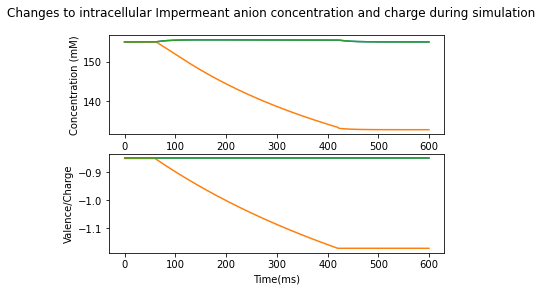

In [32]:
##################################################################
# WIDGET INITIALIZATION:

lbl_xchange = widgets.Label(value='Assess the changes to the concentration and charge of impermeant anions during the simulation')
btn_xchange = widgets.Button(description='Plot impermeant changes', button_style='info')

output_xchange = widgets.Output()

display(lbl_xchange,btn_xchange,output_xchange)


##################################################################
# IMPLEMENTATION:

          



def plot_xchange_graph():
    
    fig_xchange,(ax_conc,ax_charge) = mplt.subplots(2,1)
    fig_xchange.suptitle('Changes to intracellular Impermeant anion concentration and charge during simulation')
    ax_conc.set_ylabel("Concentration (mM)")
    ax_charge.set_ylabel("Valence/Charge")
    ax_charge.set_xlabel("Time(ms)")
    
  

    for i in range(len(comp_names_arr)):
        y_arr = [master_arr[i][j][7]*1e3 for j in range(len(interval_arr))]
        ax_conc.plot(t_arr,y_arr, label = comp_names_arr[i])
        y_arr = [master_arr[i][j][8] for j in range(len(interval_arr))]
        ax_charge.plot(t_arr,y_arr, label = comp_names_arr[i])
    
    
def btn_xchange_clicked(b):
    output_xchange.clear_output()
    with output_xchange:
        plot_xchange_graph()
    

btn_xchange.on_click(btn_xchange_clicked)

#l = len(comp_arr[1].z_arr)


#print(comp_arr[1].z_diff)

#for j in range (1000):
    #print(comp_arr[0].z_arr[round(l/1000*j)])

#print(comp_arr[2].z_arr)

#print(xflux_rate)
#print(comp_arr[0].flux_rate)

## C) Compartment Equilibria

In [33]:
#############################################################################################################
# Widget interface
output_equilib = widgets.Output()
output_equilib.layout = Layout(border='solid')
output_equilib_save = widgets.Output(Layout=Layout(border='solid'))
output_legend = widgets.Output()
btn_equilib = widgets.Button(description ="View Equilibrium dynamic",button_style='info')
btn_equilib_save = widgets.Button(description = "Save Graph as png",button_style='info')

drp_equilib = widgets.Dropdown(description ="Compartment")
options_arr = []


for i in range(len(comp_names_arr)):
    options_arr.append(comp_names_arr[i]) 
    
drp_equilib.options = options_arr


display(drp_equilib, btn_equilib, output_equilib, output_equilib_save)

#############################################################################################################
# Creating Equilibria figures



def btn_equilib_clicked(b):
    
    #### Instantiating figure
    
    
    with output_equilib_save:
        display(btn_equilib_save)
    
    
    
    #ISOLATING SPECIFIC COMPARTMENT
    temp_name = drp_equilib.value 
    temp_num = 0 
    
    for i in range(len(comp_names_arr)):
        if comp_names_arr[i] == temp_name:
            temp_num = i
            
    shapes_arr =[]
    
    with output_equilib:
        
        output_equilib.clear_output()
        
        f1 = mplt.figure(figsize=(25,10))
        ax = mplt.gca()
        
        ######### Main compartment:
        
        mainx = 32 #starting x-coordinate for main rectangle if not the last compartment
        mainy = 4  #starting y-coordinate for main rectangle
        main_rect = mpatches.Rectangle([mainx,mainy],20,16, fc='#c4c4ff',ec='red')
        main_atpase = mpatches.Ellipse([mainx+3,mainy+16],width=2, height=4,fc = '#964b00')
        main_kcc2 = mpatches.Ellipse([mainx+8,mainy+16],width=4, height=2,fc = '#8f4f66')
        shapes_arr.append(main_rect)
        shapes_arr.append(main_atpase)
        shapes_arr.append(main_kcc2)
        
        m_net_in = 0
        m_net_out = 0

        ######## Main ATPASE:
        
        m_na_atpase = master_arr[temp_num][-1][11]*1e10
        if m_na_atpase >0: #Sodium coming into the compartment
            m_na_atpase_arrow = mpatches.FancyArrow(mainx+3, mainy+16,0,-2,width=0.2,ec='#e7298a',fc='#e7298a',ls='--')
            ax.text(mainx+2.5,mainy+12.5, str(round(m_na_atpase,1)), fontsize=11)
            m_net_in += m_na_atpase
        else:
            m_na_atpase_arrow = mpatches.FancyArrow(mainx+3, mainy+16,0,+2,width=0.2,ec='#e7298a',fc='#e7298a',ls='--')
            ax.text(mainx+2.5,mainy+19, str(round(m_na_atpase,1)*-1), fontsize=11)
            m_net_out += -1*m_na_atpase
        shapes_arr.append(m_na_atpase_arrow)
        
        m_k_atpase = master_arr[temp_num][-1][14]*1e10
        if m_k_atpase >0: #POtassium coming into the compartment
            m_k_atpase_arrow = mpatches.FancyArrow(mainx+3, mainy+16,0,-2,width=0.2, ec='#7570b3',fc='#7570b3',ls='--')
            ax.text(mainx+2.5,mainy+12.5, str(round(m_k_atpase,1)), fontsize=11)
            m_net_in += m_k_atpase
        else:
            m_k_atpase_arrow = mpatches.FancyArrow(mainx+3, mainy+16,0,+2,width=0.2, ec='#7570b3',fc='#7570b3',ls='--')
            ax.text(mainx+2.5,mainy+19, str(round(m_k_atpase,1)*-1), fontsize=11)
            m_net_out += -1*m_k_atpase
        shapes_arr.append(m_k_atpase_arrow)
        
        ######## Main KCC2:
        
        m_k_kcc2 = master_arr[temp_num][-1][15]*1e10
        if m_k_kcc2 >0: #Potassium entering via KCC2
            m_k_kcc2_arrow = mpatches.FancyArrow(mainx+7, mainy+16,0,-2,width=0.2,ec='#7570b3',fc='#7570b3',ls='--')
            ax.text(mainx+6.5,mainy+12.5, str(round(m_k_kcc2,1)), fontsize=11)
            m_net_in += m_k_kcc2
        else:
            m_k_kcc2_arrow = mpatches.FancyArrow(mainx+7, mainy+16,0,+2,width=0.2,ec='#7570b3',fc='#7570b3',ls='--')
            ax.text(mainx+6.5,mainy+19, str(round(m_k_kcc2,1)*-1), fontsize=11)
            m_net_out += -1*m_k_kcc2
        shapes_arr.append(m_k_kcc2_arrow)
        
        m_cl_kcc2 = master_arr[temp_num][-1][18]*1e10
        if m_cl_kcc2 >0: #cl coming into the compartment
            m_cl_kcc2_arrow = mpatches.FancyArrow(mainx+9, mainy+16,0,-2,width=0.2, ec='#1b9e77',fc='#1b9e77',ls='--')
            ax.text(mainx+8.5,mainy+12.5, str(round(m_cl_kcc2,1)), fontsize=11)
            m_net_in -= m_cl_kcc2
        else:
            m_cl_kcc2_arrow = mpatches.FancyArrow(mainx+9, mainy+16,0,+2,width=0.2, ec='#1b9e77',fc='#1b9e77',ls='--')
            ax.text(mainx+8.5,mainy+19, str(round(m_cl_kcc2,1)*-1), fontsize=11)
            m_net_out += m_cl_kcc2
        shapes_arr.append(m_cl_kcc2_arrow)
        
            
        ########## Main Na Leak:
        
        m_na_leak = mpatches.Rectangle([mainx+12, mainy+15.5], 2,1,fc='#000000')
        shapes_arr.append(m_na_leak)
        
        m_d_na = master_arr[temp_num][-1][10]*1e10
        if m_d_na >0: #sodium coming into the compartment
            m_na_arrow = mpatches.FancyArrow(mainx+13, mainy+16, 0, -2, width=0.2,ec='#e7298a',fc='#e7298a')
            ax.text(mainx+12.5,mainy+12,str(round(m_d_na,1)), fontsize=11)
            m_net_in += m_d_na #adding sodium coming in
        else:
            m_na_arrow = mpatches.FancyArrow(mainx+13, mainy+16, 0, +2, width=0.2,ec='#e7298a',fc='#e7298a')
            ax.text(mainx+12.5,mainy+19,str(round(m_d_na,1)), fontsize=11)
            m_net_out += -1*m_d_na
        shapes_arr.append(m_na_arrow)

        ########## Main K Leak:
        
        m_k_leak = mpatches.Rectangle([mainx+15, mainy+15.5], 2,1,fc='#000000')
        shapes_arr.append(m_k_leak)
        
        m_d_k = master_arr[temp_num][-1][13]*1e10
        if m_d_k >0: #potassium coming into the compartment
            m_k_arrow = mpatches.FancyArrow(mainx+16, mainy+16, 0, -2, width=0.2,ec='#7570b3',fc='#7570b3')
            ax.text(mainx+15.5,mainy+12,str(round(m_d_k,1)), fontsize=11)
            m_net_in += m_d_k
        else:
            m_k_arrow = mpatches.FancyArrow(mainx+16, mainy+16, 0, +2, width=0.2,ec='#7570b3',fc='#7570b3')
            ax.text(mainx+15.5,mainy+19,str(round(m_d_k,1)), fontsize=11)
            m_net_out += -1*m_d_k
        shapes_arr.append(m_k_arrow)

        ########## Main Cl Leak:
        
        m_cl_leak = mpatches.Rectangle([mainx+18, mainy+15.5], 2,1,fc='#000000')
        shapes_arr.append(m_cl_leak)
        
        m_d_cl = master_arr[temp_num][-1][17]*1e10
        if m_d_cl >0: #chloride coming into selected (main) compartment
            m_cl_arrow = mpatches.FancyArrow(mainx+19, mainy+16, 0, -2, width=0.2,ec='#1b9e77',fc='#1b9e77')
            ax.text(mainx+18,mainy+12,str(round(m_d_cl,1)), fontsize=11)
            m_net_in -= m_d_cl #minus chloride coming in
        else:
            m_cl_arrow = mpatches.FancyArrow(mainx+19, mainy+16, 0, +2, width=0.2,ec='#1b9e77',fc='#1b9e77')
            ax.text(mainx+18,mainy+19,str(round(m_d_cl,1)), fontsize=11)
            m_net_out += m_d_cl
        shapes_arr.append(m_cl_arrow)




        ######## Right Compartment

        rightx = mainx+22
        righty = 4
        right_comp=False
        r_net_in =0
        r_net_out =0

        if temp_num+1 != len(comp_names_arr):   #if not the last componenent, make rectangle on right

            right_comp = True
            right_rect = mpatches.Rectangle([rightx,righty],20,16, fc='#ebebff')
            right_atpase = mpatches.Ellipse([rightx+3,righty+16],width=2, height=4,fc = '#964b00')
            right_kcc2 = mpatches.Ellipse([rightx+8,righty+16],width=4, height=2,fc = '#8f4f66')
            shapes_arr.append(right_rect)
            shapes_arr.append(right_atpase)
            shapes_arr.append(right_kcc2)
            
            
            #### Right ATPase
            r_na_atpase = master_arr[temp_num+1][-1][11]*1e10
            if r_na_atpase >0: #Sodium coming into the compartment
                r_na_atpase_arrow = mpatches.FancyArrow(rightx+3, righty+16,0,-2,width=0.2,ec='#e7298a',fc='#e7298a',ls='--')
                ax.text(rightx+2.5,righty+12.5, str(round(r_na_atpase,1)), fontsize=11)
                r_net_in += r_na_atpase
            else:
                r_na_atpase_arrow = mpatches.FancyArrow(rightx+3, righty+16,0,+2,width=0.2,ec='#e7298a',fc='#e7298a',ls='--')
                ax.text(rightx+2.5,righty+19, str(round(r_na_atpase,1)*-1), fontsize=11)
                r_net_out += -1*r_na_atpase
            shapes_arr.append(r_na_atpase_arrow)

            r_k_atpase = master_arr[temp_num+1][-1][14]*1e10
            if r_k_atpase >0: #Sodium coming into the compartment
                r_k_atpase_arrow = mpatches.FancyArrow(rightx+3, righty+16,0,-2,width=0.2, ec='#7570b3',fc='#7570b3',ls='--')
                ax.text(rightx+2.5,righty+12.5, str(round(r_k_atpase,1)), fontsize=11)
                r_net_in += r_k_atpase
            else:
                r_k_atpase_arrow = mpatches.FancyArrow(rightx+3, righty+16,0,+2,width=0.2, ec='#7570b3',fc='#7570b3',ls='--')
                ax.text(rightx+2.5,righty+19, str(round(r_k_atpase,1)*-1), fontsize=11)
                r_net_out += -1*r_k_atpase
            shapes_arr.append(r_k_atpase_arrow)
            
            ######## Right KCC2:
        
            r_k_kcc2 = master_arr[temp_num+1][-1][15]*1e10
            if r_k_kcc2 >0: #Potassium entering via KCC2
                r_k_kcc2_arrow = mpatches.FancyArrow(rightx+7, righty+16,0,-2,width=0.2,ec='#7570b3',fc='#7570b3',ls='--')
                ax.text(rightx+6.5,righty+12.5, str(round(r_k_kcc2,1)), fontsize=11)
                r_net_in += r_k_kcc2
            else:
                r_k_kcc2_arrow = mpatches.FancyArrow(rightx+7, righty+16,0,+2,width=0.2,ec='#7570b3',fc='#7570b3',ls='--')
                ax.text(rightx+6.5,righty+19, str(round(r_k_kcc2,1)*-1), fontsize=11)
                r_net_out += -1*r_k_kcc2
            shapes_arr.append(r_k_kcc2_arrow)

            r_cl_kcc2 =  master_arr[temp_num+1][-1][18]*1e10
            if r_cl_kcc2 >0: #Cl coming into the compartment via KCC2
                r_cl_kcc2_arrow = mpatches.FancyArrow(rightx+9, righty+16,0,-2,width=0.2, ec='#1b9e77',fc='#1b9e77',ls='--')
                ax.text(rightx+8.5,righty+12.5, str(round(r_cl_kcc2,1)), fontsize=11)
                r_net_in += -1*r_cl_kcc2
            else:
                r_cl_kcc2_arrow = mpatches.FancyArrow(rightx+9, righty+16,0,+2,width=0.2, ec='#1b9e77',fc='#1b9e77',ls='--')
                ax.text(rightx+8.5,righty+19, str(round(r_cl_kcc2,1)*-1), fontsize=11)
                r_net_out += r_cl_kcc2
            shapes_arr.append(r_cl_kcc2_arrow)
        
            
            #d_Na
            
            r_na_leak = mpatches.Rectangle([rightx+12, righty+15.5], 2,1,fc='#000000')
            shapes_arr.append(r_na_leak)
            
            r_d_na = master_arr[temp_num+1][-1][10]*1e10
            if r_d_na >0: #sodium coming into the compartment
                r_na_arrow = mpatches.FancyArrow(rightx+13, righty+16, 0, -2, width=0.2,ec='#e7298a',fc='#e7298a')
                ax.text(rightx+12.5,righty+12,str(round(r_d_na,1)), fontsize=11)
                r_net_in +=r_d_na
            else:
                r_na_arrow = mpatches.FancyArrow(rightx+13, righty+16, 0, +2, width=0.2,ec='#e7298a',fc='#e7298a')
                ax.text(rightx+12.5,righty+19,str(round(r_d_na,1)), fontsize=11)
                r_net_out += -1*r_d_na
            shapes_arr.append(r_na_arrow)

            #d_K
            
            r_k_leak = mpatches.Rectangle([rightx+15, righty+15.5], 2,1,fc='#000000')
            shapes_arr.append(r_k_leak)
            
            r_d_k = master_arr[temp_num+1][-1][13]*1e10
            if r_d_k >0: #potassium coming into the compartment
                r_k_arrow = mpatches.FancyArrow(rightx+16, righty+16, 0, -2, width=0.2,ec='#7570b3',fc='#7570b3')
                ax.text(rightx+15.5,righty+12,str(round(r_d_k,1)), fontsize=11)
                r_net_in += r_d_k
            else:
                r_k_arrow = mpatches.FancyArrow(rightx+16, righty+16, 0, +2, width=0.2,ec='#7570b3',fc='#7570b3')
                ax.text(rightx+15.5,righty+19,str(round(r_d_k,1)), fontsize=11)
                r_net_out += -1*r_d_k
            shapes_arr.append(r_k_arrow)


            #d_Cl
            
            r_cl_leak = mpatches.Rectangle([rightx+18, righty+15.5], 2,1,fc='#000000')
            shapes_arr.append(r_cl_leak)
            
            r_d_cl = master_arr[temp_num+1][-1][17]*1e10
            if r_d_cl >0: #chloride coming into the compartment
                r_cl_arrow = mpatches.FancyArrow(rightx+19, righty+16, 0, -2, width=0.2,ec='#1b9e77',fc='#1b9e77')
                ax.text(rightx+18,righty+12,str(round(r_d_cl,1)), fontsize=11)
                r_net_in -= r_d_cl
            else:
                r_cl_arrow = mpatches.FancyArrow(rightx+19, righty+16, 0, +2, width=0.2,ec='#1b9e77',fc='#1b9e77')
                ax.text(rightx+18,righty+19,str(round(r_d_cl,1)), fontsize=11)
                r_net_out += r_d_cl
            shapes_arr.append(r_cl_arrow)

            #Right Electrodiffusion
            r_ed_arr = ED_master_arr[temp_num][-1]
            
            r_ed_na = r_ed_arr[0]*1e10
            if r_ed_na >0: 
                r_ed_na_arrow = mpatches.FancyArrow(rightx+2, righty+8, -5, 0, width=0.2,ec='#e7298a',fc='#e7298a',ls='dotted')
                ax.text(rightx+2,righty+7.75,str(round(r_ed_na,1)), fontsize=11)
                shapes_arr.append(r_ed_na_arrow)
                r_net_out += r_ed_na
                m_net_in += r_ed_na

            else: #Sodium moving out of cell
                r_ed_na_arrow = mpatches.FancyArrow(rightx-4, righty+8, +5, 0, width=0.2,ec='#e7298a',fc='#e7298a',ls ='dotted')
                ax.text(rightx+2,righty+7.75,str(round(r_ed_na,1)), fontsize=11)
                shapes_arr.append(r_ed_na_arrow)
                r_net_in += -1*r_ed_na
                m_net_out += -1*r_ed_na

            r_ed_k = r_ed_arr[1]*1e10
            if r_ed_k >0: 
                r_ed_k_arrow = mpatches.FancyArrow(rightx+2, righty+6, -5, 0, width=0.2,ec='#7570b3',fc='#7570b3')
                ax.text(rightx-7,righty+5.75,str(round(r_ed_k,1)), fontsize=11)
                shapes_arr.append(r_ed_k_arrow)
                r_net_out += r_ed_k
                m_net_in += r_ed_k
            else:
                r_ed_k_arrow = mpatches.FancyArrow(rightx-4, righty+6, +5, 0, width=0.2,ec='#7570b3',fc='#7570b3')
                ax.text(rightx+2,righty+5.75,str(round(r_ed_k,1)), fontsize=11)
                shapes_arr.append(r_ed_k_arrow)
                r_net_in -= r_ed_k
                m_net_out -= r_ed_k

            r_ed_cl = r_ed_arr[2]*1e10
            if r_ed_cl >0: 
                r_ed_cl_arrow = mpatches.FancyArrow(rightx+2, righty+4, -5, 0, width=0.2,ec='#1b9e77',fc='#1b9e77')
                ax.text(rightx-7,righty+3.75,str(round(r_ed_cl,1)),fontsize=11)
                shapes_arr.append(r_ed_cl_arrow)
                r_net_out -= r_ed_cl
                m_net_in -= r_ed_cl
            else:
                r_ed_cl_arrow = mpatches.FancyArrow(rightx-4, righty+4, +5, 0, width=0.2,ec='#1b9e77',fc='#1b9e77')
                ax.text(rightx+2,righty+3.75,str(round(r_ed_cl,1)),fontsize=11)
                shapes_arr.append(r_ed_cl_arrow)
                r_net_in += r_ed_cl
                m_net_out += r_ed_cl

            #Right Ion square:
            #r_net_rect = mpatches.Rectangle([rightx+8,righty+7],5,2.5, fc='#ebebff')
            #shapes_arr.append(r_net_rect)
            ax.text(rightx+7.5, righty+8.5,"Net in: " + str(round(r_net_in,2)),fontsize=11)
            ax.text(rightx+7.5, righty+7.5,"Net out: " + str(round(r_net_out,2)),fontsize=11) 


        ######## Left Compartment

        leftx = mainx-22
        lefty=4
        left_comp=False
        l_net_in =0
        l_net_out =0

        if temp_num+1 != 1:   #if not the first componenent, make rectangle on left

            left_comp = True
            left_rect = mpatches.Rectangle([leftx,lefty],20,16, fc='#ebebff')
            shapes_arr.append(left_rect)
            left_atpase = mpatches.Ellipse([leftx+3,lefty+16],width=2, height=4,fc = '#964b00')
            left_kcc2 = mpatches.Ellipse([leftx+8,lefty+16],width=4, height=2,fc = '#8f4f66')
            shapes_arr.append(left_atpase)
            shapes_arr.append(left_kcc2)
            
            #### Left ATPase
            l_na_atpase = master_arr[temp_num-1][-1][11]*1e10
            if l_na_atpase >0: #Sodium coming into the compartment
                l_na_atpase_arrow = mpatches.FancyArrow(leftx+3, lefty+16,0,-2,width=0.2,ec='#e7298a',fc='#e7298a',ls='--')
                ax.text(leftx+2.5,lefty+12.5, str(round(l_na_atpase,1)), fontsize=11)
                l_net_in += l_na_atpase
            else:
                l_na_atpase_arrow = mpatches.FancyArrow(leftx+3, lefty+16,0,+2,width=0.2,ec='#e7298a',fc='#e7298a',ls='--')
                ax.text(leftx+2.5,lefty+19, str(round(l_na_atpase,1)*-1), fontsize=11)
                l_net_out -= l_na_atpase
            shapes_arr.append(l_na_atpase_arrow)

            l_k_atpase = master_arr[temp_num-1][-1][14]*1e10
            if l_k_atpase >0: #Sodium coming into the compartment
                l_k_atpase_arrow = mpatches.FancyArrow(leftx+3, lefty+16,0,-2,width=0.2, ec='#7570b3',fc='#7570b3',ls='--')
                ax.text(leftx+2.5,lefty+12.5, str(round(l_k_atpase,1)),fontsize=11)
                l_net_in += l_k_atpase
            else:
                l_k_atpase_arrow = mpatches.FancyArrow(leftx+3, lefty+16,0,+2,width=0.2, ec='#7570b3',fc='#7570b3',ls='--')
                ax.text(leftx+2.5,lefty+19, str(round(l_k_atpase,1)*-1), fontsize=11)
                l_net_out -= l_k_atpase
            shapes_arr.append(l_k_atpase_arrow)
            
            ######## Left KCC2:
        
            l_k_kcc2 = master_arr[temp_num-1][-1][15]*1e10
            if l_k_kcc2 >0: #Potassium entering via KCC2
                l_k_kcc2_arrow = mpatches.FancyArrow(leftx+7, lefty+16,0,-2,width=0.2,ec='#7570b3',fc='#7570b3',ls='--')
                ax.text(leftx+6.5,lefty+12.5, str(round(l_k_kcc2,1)),fontsize=11)
                l_net_in += l_k_kcc2
            else:
                l_k_kcc2_arrow = mpatches.FancyArrow(leftx+7, lefty+16,0,+2,width=0.2,ec='#7570b3',fc='#7570b3',ls='--')
                ax.text(leftx+6.5,lefty+19, str(round(l_k_kcc2,1)*-1),fontsize=11)
                l_net_out -= l_k_kcc2
            shapes_arr.append(l_k_kcc2_arrow)

            l_cl_kcc2 = master_arr[temp_num-1][-1][18]*1e10
            if l_cl_kcc2 >0: #Sodium coming into the compartment
                l_cl_kcc2_arrow = mpatches.FancyArrow(leftx+9, lefty+16,0,-2,width=0.2, ec='#1b9e77',fc='#1b9e77',ls='--')
                ax.text(leftx+8.5,lefty+12.5, str(round(l_cl_kcc2,1)),fontsize=11)
                l_net_in -= l_cl_kcc2
            else:
                l_cl_kcc2_arrow = mpatches.FancyArrow(leftx+9, lefty+16,0,+2,width=0.2, ec='#1b9e77',fc='#1b9e77',ls='--')
                ax.text(leftx+8.5,lefty+19, str(round(l_cl_kcc2,1)*-1),fontsize=11)
                l_net_out += l_cl_kcc2
            shapes_arr.append(l_cl_kcc2_arrow)
            
            #d_Na
            
            l_na_leak = mpatches.Rectangle([leftx+12, lefty+15.5], 2,1,fc='#000000')
            shapes_arr.append(l_na_leak)
            
            l_d_na = master_arr[temp_num-1][-1][10]*1e10
            if l_d_na >0: #sodium coming into the left compartment
                l_na_arrow = mpatches.FancyArrow(leftx+13, lefty+16, 0, -2, width=0.2, ec='#e7298a',fc='#e7298a')
                ax.text(leftx+12.5,lefty+12,str(round(l_d_na,1)), fontsize=11)
                l_net_in += l_d_na
            else:
                l_na_arrow = mpatches.FancyArrow(leftx+13, lefty+16, 0, +2, width=0.2,ec='#e7298a',fc='#e7298a')
                ax.text(leftx+12.5,lefty+19,str(round(l_d_na,1)), fontsize=11)
                l_net_out += -1*l_d_na
            shapes_arr.append(l_na_arrow)

            #d_K
            
            l_k_leak = mpatches.Rectangle([leftx+15, lefty+15.5], 2,1,fc='#000000')
            shapes_arr.append(l_k_leak)
            
            l_d_k = master_arr[temp_num-1][-1][13]*1e10
            if l_d_k >0: #potassium coming into the compartment
                l_k_arrow = mpatches.FancyArrow(leftx+16, lefty+16, 0, -2, width=0.2,ec='#7570b3',fc='#7570b3')
                ax.text(leftx+15.5,lefty+12,str(round(l_d_k,1)),fontsize=11)
                l_net_in += l_d_k
            else:
                l_k_arrow = mpatches.FancyArrow(leftx+16, lefty+16, 0, +2, width=0.2,ec='#7570b3',fc='#7570b3')
                ax.text(leftx+15.5,lefty+19,str(round(l_d_k,1)), fontsize=11)
                l_net_out += -1*l_d_k
            shapes_arr.append(l_k_arrow)


            #d_Cl
            
            l_cl_leak = mpatches.Rectangle([leftx+18, lefty+15.5], 2,1,fc='#000000')
            shapes_arr.append(l_cl_leak)
            
            l_d_cl = master_arr[temp_num-1][-1][17]*1e10
            if l_d_cl >0: #chloride coming into the compartment
                l_cl_arrow = mpatches.FancyArrow(leftx+19, lefty+16, 0, -2, width=0.2,ec='#1b9e77',fc='#1b9e77')
                ax.text(leftx+18,lefty+12,str(round(l_d_cl,1)), fontsize=11)
                l_net_in += -1*l_d_cl
            else:
                l_cl_arrow = mpatches.FancyArrow(leftx+19, lefty+16, 0, +2, width=0.2,ec='#1b9e77',fc='#1b9e77')
                ax.text(leftx+18,lefty+19,str(round(l_d_cl,1)), fontsize=11)
                l_net_out += l_d_cl
            shapes_arr.append(l_cl_arrow)


            #Left compartment boundary (electrodiffusion):
            
            l_ed_arr = ED_master_arr[temp_num-1][-1]

            l_ed_na = l_ed_arr[0]*1e10
            if l_ed_na >0: #sodium leaving the L compartment, entering main compartment via ED
                l_ed_na_arrow = mpatches.FancyArrow(mainx+2, mainy+8, -5, 0, width=0.2,ec='#e7298a',fc='#e7298a',hatch ='+')
                ax.text(mainx-7,mainy+7.75,str(round(l_ed_na,1)),fontsize=11)
                shapes_arr.append(l_ed_na_arrow)
                l_net_in += l_ed_na
                m_net_out += l_ed_na
            else: # sodium entering via ED
                l_ed_na_arrow = mpatches.FancyArrow(mainx-4, mainy+8, +5, 0, width=0.2,ec='#e7298a',fc='#e7298a',ls =':')
                ax.text(mainx+2,mainy+7.75,str(round(l_ed_na,1)), fontsize=11)
                shapes_arr.append(l_ed_na_arrow)
                l_net_out -= l_ed_na
                m_net_in -= l_ed_na

            l_ed_k = l_ed_arr[1]*1e10
            if l_ed_k >0: #K leaving the compartment via ED
                l_ed_k_arrow = mpatches.FancyArrow(mainx+2, mainy+6, -5, 0, width=0.2,ec='#7570b3',fc='#7570b3')
                ax.text(mainx-7,mainy+5.75,str(round(l_ed_k,1)), fontsize=11)
                shapes_arr.append(l_ed_k_arrow)
                l_net_in += l_ed_k
                m_net_out += l_ed_k
            else:
                l_ed_k_arrow = mpatches.FancyArrow(mainx-4, mainy+6, +5, 0, width=0.2,ec='#7570b3',fc='#7570b3')
                ax.text(mainx+2,mainy+5.75,str(round(l_ed_k,1)), fontsize=11)
                shapes_arr.append(l_ed_k_arrow)
                l_net_out -= l_ed_k
                m_net_in -= l_ed_k

            l_ed_cl = l_ed_arr[2]*1e10
            if l_ed_cl >0: #sodium coming into the compartment
                l_ed_cl_arrow = mpatches.FancyArrow(mainx+2, mainy+4, -5, 0, width=0.2,ec='#1b9e77',fc='#1b9e77')
                ax.text(mainx-7,mainy+3.75,str(round(l_ed_cl,1)), fontsize=11)
                shapes_arr.append(l_ed_cl_arrow)
                l_net_in -= l_ed_cl
                m_net_out -= l_ed_cl
            else:
                l_ed_cl_arrow = mpatches.FancyArrow(mainx-4, mainy+4, +5, 0, width=0.2,ec='#1b9e77',fc='#1b9e77')
                ax.text(mainx+2,mainy+3.75,str(round(l_ed_cl,1)), fontsize=11)
                shapes_arr.append(l_ed_cl_arrow)
                l_net_out += l_ed_cl
                m_net_in += l_ed_cl



            #Left Ion square:
            #l_net_rect = mpatches.Rectangle([leftx+8,lefty+7],5,2.5, fc='#ebebff')
            #shapes_arr.append(l_net_rect)
            ax.text(leftx+7.5, lefty+8.5,"Net in: " + str(round(l_net_in,2)),fontsize=11)
            ax.text(leftx+7.5, lefty+7.5,"Net out: " + str(round(l_net_out,2)),fontsize=11)

        #Net Ion square:
        #m_net_rect = mpatches.Rectangle([mainx+8,mainy+7],5,2.5,fc='#ebebff')
        #shapes_arr.append(m_net_rect)
        ax.text(mainx+7.5, mainy+8.5,"Net in: " + str(round(m_net_in,2)),fontsize=11)
        ax.text(mainx+7.5, mainy+7.5,"Net out: " + str(round(m_net_out,2)),fontsize=11)



        ######### legend
        leg_rect = mpatches.Rectangle([65,32],8,12, fc='white', ec='black')
        shapes_arr.append(leg_rect)
        ax.text(65.5,44.2,"Legend", fontsize=13)
        
        leg_na_arrow = mpatches.FancyArrow(69, 42.5, 2, 0, width=0.1,ec='#e7298a',fc='#e7298a')
        shapes_arr.append(leg_na_arrow)
        ax.text(65.5,42.5,"Na+", fontsize=12)
        
        leg_k_arrow = mpatches.FancyArrow(69, 41, 2, 0, width=0.1,ec='#7570b3',fc='#7570b3')
        shapes_arr.append(leg_k_arrow)
        ax.text(65.5,41,"K+", fontsize=12)
        
        leg_cl_arrow = mpatches.FancyArrow(69, 39.5, 2, 0, width=0.1,ec='#1b9e77',fc='#1b9e77')
        shapes_arr.append(leg_cl_arrow)
        ax.text(65.5,39.5,"Cl-", fontsize=12)
        
        leg_atpase = mpatches.Ellipse([71,37],width=1, height=2,fc = '#964b00')
        shapes_arr.append(leg_atpase)
        ax.text(65.5,37,"ATPase", fontsize=12)
        
        leg_kcc2 = mpatches.Ellipse([71,35],width=2, height=1,fc = '#8f4f66')
        shapes_arr.append(leg_kcc2)
        ax.text(65.5,35,"KCC2", fontsize=12)
        
        leg_leak = mpatches.Rectangle([70, 33], 2,1,fc='#000000')
        shapes_arr.append(leg_leak)
        ax.text(65.5,33,"Leak", fontsize=12)




        for j in range(len(shapes_arr)):
            ax.add_patch(shapes_arr[j])

        

        ax.text(mainx+8.5,mainy+1,temp_name, fontsize=16)

        if left_comp == True: 
            ax.text(leftx+8.5,lefty+1,comp_names_arr[temp_num-1], fontsize=16)

        if right_comp == True: 
            ax.text(rightx+8.5,righty+1,comp_names_arr[temp_num+1], fontsize=16)

        mplt.axis("Scaled")
        #ax.text(mainx,30,"**All values are in 10^6 mM", fontsize=16)
        ax.axis("off")
        
        mplt.show()
        
        def btn_equilib_save_clicked(b):
    
            f1.savefig("BOUNDARY",format='png')
            print("Figure titled BOUNDARY saved in local directory")
                       
        btn_equilib_save.on_click(btn_equilib_save_clicked)


        
###########################################################################################################        
        

        
        

#############################################################################################################    
# Connecting button to backend

btn_equilib.on_click(btn_equilib_clicked)


Dropdown(description='Compartment', options=('Comp1', 'Comp2', 'Comp3'), value='Comp1')

Button(button_style='info', description='View Equilibrium dynamic', style=ButtonStyle())

Output(layout=Layout(border='solid'))

Output()